In [1]:
%load_ext autoreload
%autoreload 2

In [23]:
from IPython.display import clear_output

import pickle as pk
import algorithms as algo

import numpy as np
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.special import logsumexp
import pandas as pd
import pandasql as ps
from copy import deepcopy
from scipy.optimize import minimize 
from tqdm import tqdm_notebook
import plotting as my_plt
from common import average_max
import auto_theta as ath
import common as cmn

In [3]:
class Env:
    def __init__(self,peak1, peak2, sigma1, sigma2):
        self.peak1 = peak1
        self.peak2 = peak2
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.f1 = multivariate_normal(peak1, sigma1)
        self.f2 = multivariate_normal(peak2, sigma2)
        
    def __call__(self,data):
        return (self.f1.pdf(data) + self.f2.pdf(data))/max(self.f1.pdf(self.peak1) + self.f2.pdf(self.peak1)\
                                            , self.f1.pdf(self.peak2) + self.f2.pdf(self.peak2))

## One relrvant source case

Sources and target initialization:

In [110]:
params = [([i,i], [j,j], np.eye(2), np.eye(2)*0.25) for i,j in zip([-5,0.8,5,6],[-3,2.8,1,4])]
sources = [Env(*args) for args in params]

In [111]:
f = Env([0.7]*2, [2.7]*2, np.eye(2), np.eye(2)*0.25)

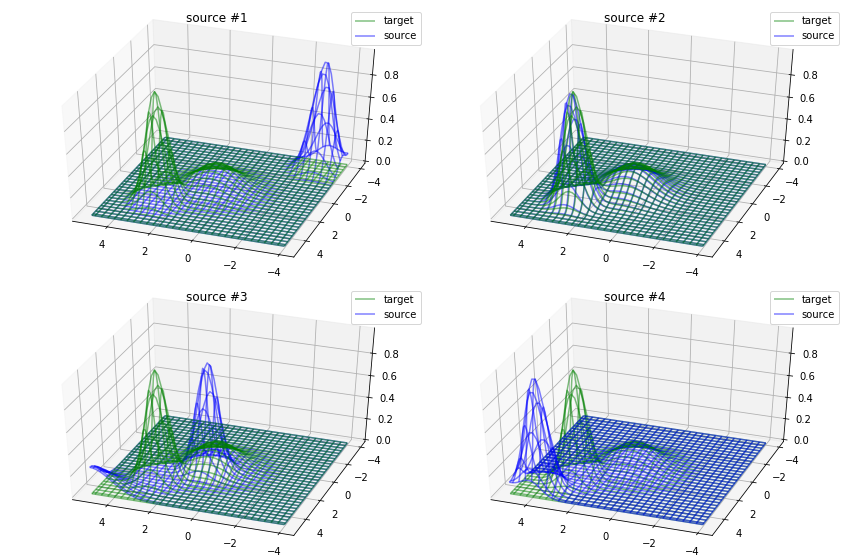

In [112]:
theta = np.linspace(-4., 5., 60)
X, Y = np.meshgrid(theta,theta)
data = np.append(X.reshape(-1,1), Y.reshape(-1,1), axis = -1)

fig = my_plt.plot_sources(sources, f, X, Y, data)
fig.subplots_adjust(wspace=0, hspace=0.05)

Data generation:

In [113]:
bounds = np.array([[-4,5], [-4,5]])

theta = np.linspace(-4., 5., 10)
X, Y = np.meshgrid(theta,theta)
data = np.append(X.reshape(-1,1), Y.reshape(-1,1), axis = -1)

Search grid initialization:

In [114]:
theta = np.linspace(-4., 5., 30)
X, Y = np.meshgrid(theta,theta)
search_grid = np.append(X.reshape(-1,1), Y.reshape(-1,1), axis = -1)

pd_data = pd.DataFrame(data, columns=['x', 'y'])
pd_grid = pd.DataFrame(search_grid, columns=['x', 'y'])

query = '''
select * from pd_grid
except
select * from pd_data
'''

pd_grid = ps.sqldf(query)

search_grid = np.array(pd_grid)

Starting points initialization:

In [115]:
num_starts = 10

starting_points = [np.random.RandomState(seed=42+i).uniform([-4,-4], [5,5], size=(2,2))\
                   for i in range(num_starts)]

In [116]:
history ={} #history of algorithms launches

#exp3 algorithm results
res = []
for st_points_ in starting_points:
    res += [algo.envelope_gp(sources, data, f, st_points_, bounds, algo.myLoss1, search_grid, n_restarts=5,\
            number_of_iterations=30, strategy='exp3-auer')]
    clear_output()
    
history['exp3-auer'] = res


In [117]:
#transfer learning algorithm results
res = []
for st_points_ in starting_points:
    res += [algo.SMBO_transfer(sources, data, f, st_points_, bounds, search_grid,\
                               n_restarts=5, number_of_iterations=30, forget=20)]
    clear_output()
history['SMBO_transfer_oh'] = res


In [118]:
#no transfer algorithm results
res = []
for st_points_ in starting_points:
    res += [algo.envelope_gp([], data, f, st_points_, bounds, algo.myLoss1, search_grid,\
                             n_restarts=5, number_of_iterations=30, forget=10, forget_upd=0.9)]
    clear_output()
history['simple_bo'] = res

In [119]:
#exp3-IX algorithm results
res = []
for st_points_ in starting_points:
    res += [algo.envelope_gp(sources, data, f, st_points_, bounds, algo.myLoss1, search_grid,\
                             n_restarts=5, number_of_iterations=30, strategy='exp3-IX')]
    clear_output()
history['exp3-IX'] = res

In [120]:
#exp3-IX with acquisition parameters tuning
res = []
for st_points_ in starting_points:
    res += [ath.envelope_gp_cnn_theta(sources, data, f, st_points_, bounds, algo.myLoss1, search_grid,\
                             n_restarts=5, number_of_iterations=30, strategy='exp3-IX')]
    clear_output()
history['exp3-IX_cnn'] = res

Average of 10 launches:

In [121]:
exp3_res  =\
    cmn.average_max([obj[0] for obj in history['exp3-auer']], f)
exp3_ix_res = cmn.average_max([obj[0] for obj in history['exp3-IX']], f)
smbo_oh_res = cmn.average_max([obj[0] for obj in history['SMBO_transfer_oh']], f)
exp3_IX_cnn_res =  cmn.average_max([obj[0] for obj in history['exp3-IX_cnn']], f)
simple_bo_res = cmn.average_max([obj[0] for obj in history['simple_bo']], f)

Plot the results:

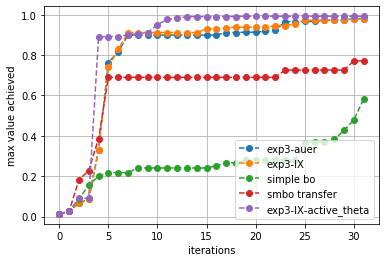

In [122]:
fig = my_plt.plot_exp_res(['exp3-auer', 'exp3-IX',\
                    'simple bo', 'smbo transfer', 'exp3-IX-active_theta'],\
                   [exp3_res, exp3_ix_res, simple_bo_res, smbo_oh_res, exp3_IX_cnn_res])

Plot distribution over sources:

Text(0.5, 1.0, 'exp3-IX')

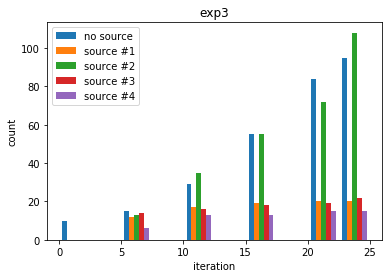

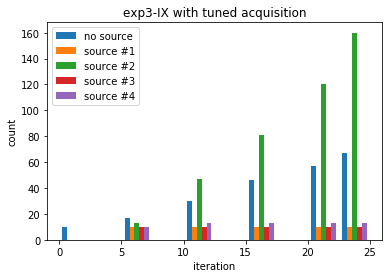

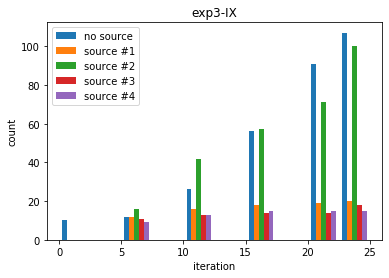

In [123]:
my_plt.count_arms([i[1] for i in history['exp3-auer']], len(sources))
plt.title('exp3')

ax[1] = my_plt.count_arms([i[1] for i in history['exp3-IX_cnn']], len(sources))
plt.title('exp3-IX with tuned acquisition')

ax[2] = my_plt.count_arms([i[1] for i in history['exp3-IX']], len(sources))
plt.title('exp3-IX')

## Two relrvant source case

In [177]:
history={}

Sources and target initialization:

In [178]:
params = [([i,i], [j,j], np.eye(2), np.eye(2)*0.25) for i,j in zip([-5,0.8,0.4,6],[-3,2.8,2.4,4])]
sources = [Env(*args) for args in params]

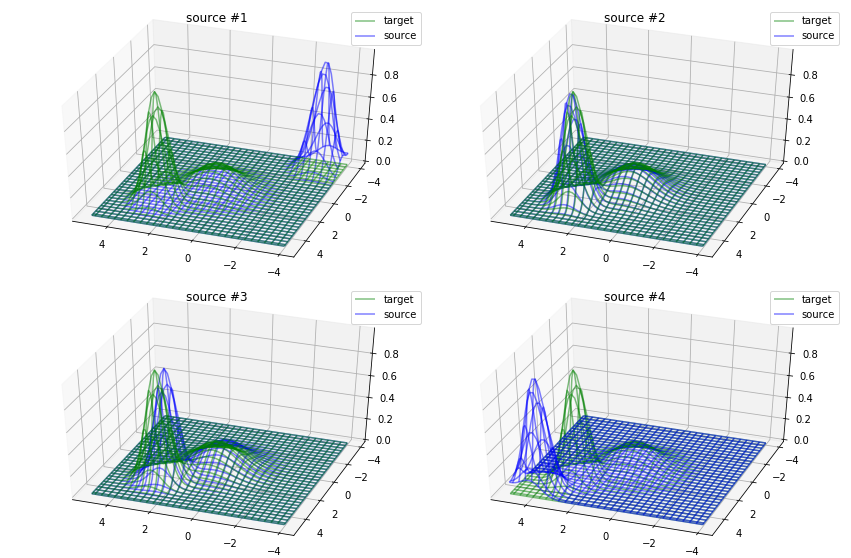

In [179]:
theta = np.linspace(-4., 5., 60)
X, Y = np.meshgrid(theta,theta)
data = np.append(X.reshape(-1,1), Y.reshape(-1,1), axis = -1)

fig = my_plt.plot_sources(sources, f, X, Y, data)
fig.subplots_adjust(wspace=0, hspace=0.05)

Data generation:

In [180]:
bounds = np.array([[-4,5], [-4,5]])

theta = np.linspace(-4., 5., 10)
X, Y = np.meshgrid(theta,theta)
data = np.append(X.reshape(-1,1), Y.reshape(-1,1), axis = -1)

#add points nearby peaks to data 
peaks = np.array([p[1] for p in params])
X, Y = np.meshgrid(theta,theta)
add_points = []
for i in peaks[1:3]:
    add_points += np.random.RandomState(seed=8).multivariate_normal(i, 0.15*np.eye(2), 4).tolist()
data = np.append(data, add_points, axis=0)

Search grid initialization:

In [181]:
theta = np.linspace(-4., 5., 30)
X, Y = np.meshgrid(theta,theta)
search_grid = np.append(X.reshape(-1,1), Y.reshape(-1,1), axis = -1)

pd_data = pd.DataFrame(data, columns=['x', 'y'])
pd_grid = pd.DataFrame(search_grid, columns=['x', 'y'])

query = '''
select * from pd_grid
except
select * from pd_data
'''

pd_grid = ps.sqldf(query)

search_grid = np.array(pd_grid)

Starting points initialization:

In [182]:
num_starts = 10

starting_points = [np.random.RandomState(seed=42+i).uniform([-4,-4], [5,5], size=(2,2))\
                   for i in range(num_starts)]

In [183]:
history ={} #history of algorithms launches

#exp3 algorithm results
res = []
for st_points_ in starting_points:
    res += [algo.envelope_gp(sources, data, f, st_points_, bounds, algo.myLoss1, search_grid, n_restarts=5,\
            number_of_iterations=30, strategy='exp3-auer', forget=20)]
    clear_output()
    
history['exp3-auer'] = res


In [184]:
#transfer learning algorithm results
res = []
for st_points_ in starting_points:
    res += [algo.SMBO_transfer(sources, data, f, st_points_, bounds, search_grid,\
                               n_restarts=5, number_of_iterations=30, forget=20)]
    clear_output()
history['SMBO_transfer_oh'] = res


In [185]:
#no transfer algorithm results
res = []
for st_points_ in starting_points:
    res += [algo.envelope_gp([], data, f, st_points_, bounds, algo.myLoss1, search_grid,\
                             n_restarts=5, number_of_iterations=30, forget=10, forget_upd=0.9)]
    clear_output()
history['simple_bo'] = res

In [186]:
#exp3-IX algorithm results
res = []
for st_points_ in starting_points:
    res += [algo.envelope_gp(sources, data, f, st_points_, bounds, algo.myLoss1, search_grid,\
                             n_restarts=5, number_of_iterations=30, strategy='exp3-IX', forget=20)]
    clear_output()
history['exp3-IX'] = res

In [187]:
#exp3-IX with acquisition parameters tuning
res = []
for st_points_ in starting_points:
    res += [ath.envelope_gp_cnn_theta(sources, data, f, st_points_, bounds, algo.myLoss1, search_grid,\
                             n_restarts=5, number_of_iterations=30, strategy='exp3-IX', forget=20)]
    clear_output()
history['exp3-IX_cnn'] = res

Average of 10 launches:

In [188]:
exp3_res  =\
    cmn.average_max([obj[0] for obj in history['exp3-auer']], f)
exp3_ix_res = cmn.average_max([obj[0] for obj in history['exp3-IX']], f)
smbo_oh_res = cmn.average_max([obj[0] for obj in history['SMBO_transfer_oh']], f)
exp3_IX_cnn_res =  cmn.average_max([obj[0] for obj in history['exp3-IX_cnn']], f)
simple_bo_res = cmn.average_max([obj[0] for obj in history['simple_bo']], f)

Plot the results:

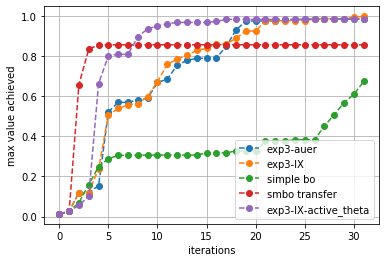

In [189]:
fig = my_plt.plot_exp_res(['exp3-auer', 'exp3-IX',\
                    'simple bo', 'smbo transfer', 'exp3-IX-active_theta'],\
                   [exp3_res, exp3_ix_res, simple_bo_res, smbo_oh_res, exp3_IX_cnn_res])

Plot distribution over sources:

Text(0.5, 1.0, 'exp3-IX')

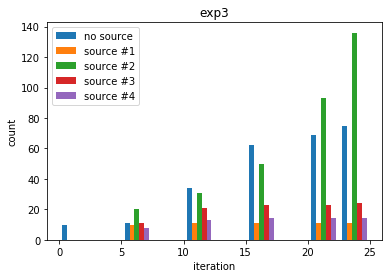

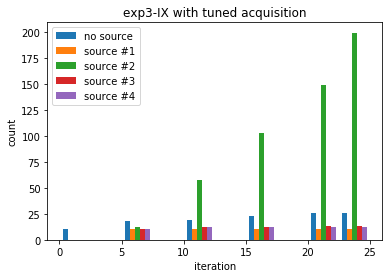

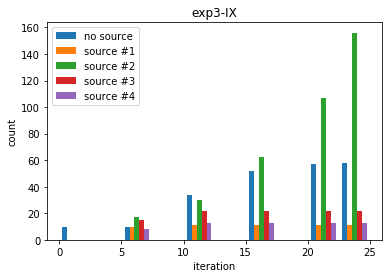

In [190]:
my_plt.count_arms([i[1] for i in history['exp3-auer']], len(sources))
plt.title('exp3')

ax[1] = my_plt.count_arms([i[1] for i in history['exp3-IX_cnn']], len(sources))
plt.title('exp3-IX with tuned acquisition')

ax[2] = my_plt.count_arms([i[1] for i in history['exp3-IX']], len(sources))
plt.title('exp3-IX')

### No relevant source case 

In [223]:
history={}

Sources and target initialization:

In [224]:
params = [([i,i], [j,j], np.eye(2), np.eye(2)*0.25) for i,j in zip([-5,4.5,5,6],[-3,6.5,4,4])]
sources = [Env(*args) for args in params]

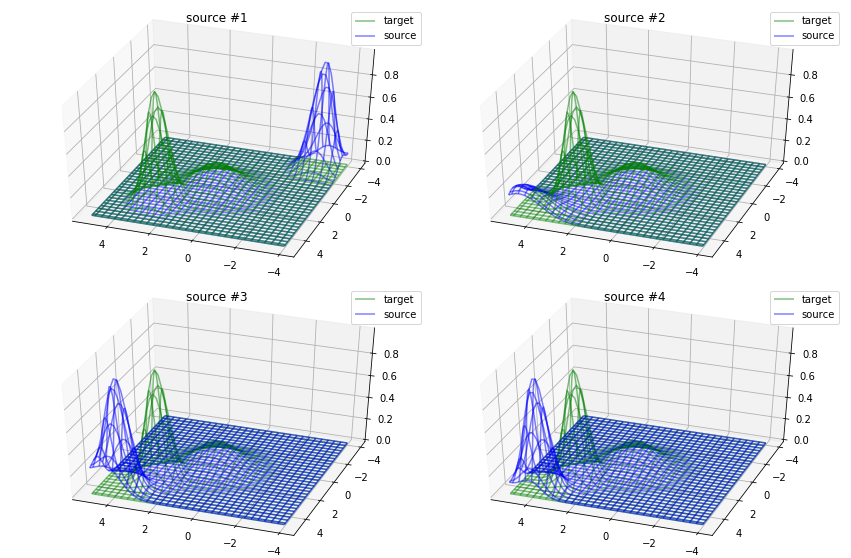

In [225]:
theta = np.linspace(-4., 5., 60)
X, Y = np.meshgrid(theta,theta)
data = np.append(X.reshape(-1,1), Y.reshape(-1,1), axis = -1)

fig = my_plt.plot_sources(sources, f, X, Y, data)
fig.subplots_adjust(wspace=0, hspace=0.05)

Data generation:

In [226]:
bounds = np.array([[-4,5], [-4,5]])

theta = np.linspace(-4., 5., 10)
X, Y = np.meshgrid(theta,theta)
data = np.append(X.reshape(-1,1), Y.reshape(-1,1), axis = -1)

#add points nearby peaks to data 
peaks = np.array([p[1] for p in params])
X, Y = np.meshgrid(theta,theta)
add_points = []
for i in peaks[1:3]:
    add_points += np.random.RandomState(seed=8).multivariate_normal(i, 0.15*np.eye(2), 4).tolist()
data = np.append(data, add_points, axis=0)

Search grid initialization:

In [227]:
theta = np.linspace(-4.5, 5, 30)
X, Y = np.meshgrid(theta,theta)
search_grid = np.append(X.reshape(-1,1), Y.reshape(-1,1), axis = -1)

pd_data = pd.DataFrame(data, columns=['x', 'y'])
pd_grid = pd.DataFrame(search_grid, columns=['x', 'y'])

query = '''
select * from pd_grid
except
select * from pd_data
'''

pd_grid = ps.sqldf(query)

search_grid = np.array(pd_grid)

Starting points initialization:

In [228]:
num_starts = 10

starting_points = [np.random.RandomState(seed=42+i).uniform([-4,-4], [5,5], size=(2,2))\
                   for i in range(num_starts)]

In [229]:
history ={} #history of algorithms launches

#exp3 algorithm results
res = []
for st_points_ in starting_points:
    res += [algo.envelope_gp(sources, data, f, st_points_, bounds, algo.myLoss1, search_grid, n_restarts=5,\
            number_of_iterations=30, strategy='exp3-auer', forget=10, forget_upd=0.8)]
    clear_output()
    
history['exp3-auer'] = res


In [233]:
#transfer learning algorithm results
res = []
for st_points_ in starting_points:
    res += [algo.SMBO_transfer(sources, data, f, st_points_, bounds, search_grid,\
                               n_restarts=5, number_of_iterations=30, forget=20)]
    clear_output()
history['SMBO_transfer_oh'] = res


In [234]:
#no transfer algorithm results
res = []
for st_points_ in starting_points:
    res += [algo.envelope_gp([], data, f, st_points_, bounds, algo.myLoss1, search_grid,\
                             n_restarts=5, number_of_iterations=30, forget=10, forget_upd=0.9)]
    clear_output()
history['simple_bo'] = res

In [230]:
#exp3-IX algorithm results
res = []
for st_points_ in starting_points:
    res += [algo.envelope_gp(sources, data, f, st_points_, bounds, algo.myLoss1, search_grid,\
                             n_restarts=5, number_of_iterations=30, strategy='exp3-IX', forget=10, forget_upd=0.8)]
    clear_output()
history['exp3-IX'] = res

In [231]:
#exp3-IX with acquisition parameters tuning
res = []
for st_points_ in starting_points:
    res += [ath.envelope_gp_cnn_theta(sources, data, f, st_points_, bounds, algo.myLoss1, search_grid,\
                             n_restarts=5, number_of_iterations=30, strategy='exp3-IX')]
    clear_output()
history['exp3-IX_cnn'] = res

Average of 10 launches:

In [235]:
exp3_res  =\
    cmn.average_max([obj[0] for obj in history['exp3-auer']], f)
exp3_ix_res = cmn.average_max([obj[0] for obj in history['exp3-IX']], f)
smbo_oh_res = cmn.average_max([obj[0] for obj in history['SMBO_transfer_oh']], f)
exp3_IX_cnn_res =  cmn.average_max([obj[0] for obj in history['exp3-IX_cnn']], f)
simple_bo_res = cmn.average_max([obj[0] for obj in history['simple_bo']], f)

Plot the results:

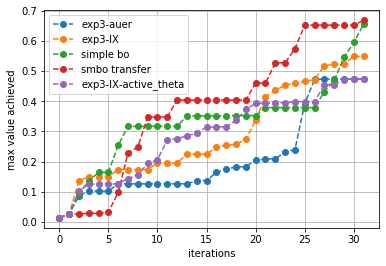

In [236]:
fig = my_plt.plot_exp_res(['exp3-auer', 'exp3-IX',\
                    'simple bo', 'smbo transfer', 'exp3-IX-active_theta'],\
                   [exp3_res, exp3_ix_res, simple_bo_res, smbo_oh_res, exp3_IX_cnn_res])

Plot distribution over sources:

Text(0.5, 1.0, 'exp3-IX')

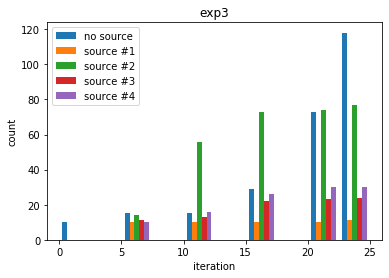

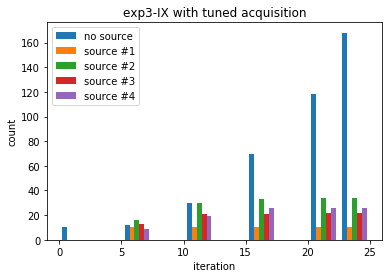

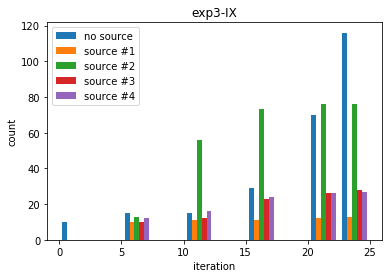

In [237]:
my_plt.count_arms([i[1] for i in history['exp3-auer']], len(sources))
plt.title('exp3')

ax[1] = my_plt.count_arms([i[1] for i in history['exp3-IX_cnn']], len(sources))
plt.title('exp3-IX with tuned acquisition')

ax[2] = my_plt.count_arms([i[1] for i in history['exp3-IX']], len(sources))
plt.title('exp3-IX')